<a href="https://colab.research.google.com/github/YChen1212/Food-Delivery-Profit-Analysis-with-K-Means-Clustering/blob/main/Food_Delivery_Profit_Analysis_with_K_Means_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **外送平台消費者分群分析**

## 一、 資料載入與瀏覽

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

### 1.1 讀取 Google Drive 檔案

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/python練習/food_orders.csv')
df.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


### 1.2 檢視缺失值


In [ ]:
df.isna().sum()

,0
Order ID,0
Customer ID,0
Restaurant ID,0
Order Date and Time,0
Delivery Date and Time,0
Order Value,0
Delivery Fee,0
Payment Method,0
Discounts and Offers,185
Commission Fee,0


### 1.3 檢視欄位資料型態

In [ ]:
df.info()
# 有185個訂單沒有折扣

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    815 non-null    object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB


### 1.4 敘述統計摘要

In [ ]:
df.describe()

,Order ID,Order Value,Delivery Fee,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,1053.969000,28.620000,126.99000,29.832000,28.300000
std,288.819436,530.975339,16.958278,43.06405,11.627165,49.614228
min,1.000000,104.000000,0.000000,50.00000,10.000000,0.000000
25%,250.750000,597.750000,20.000000,90.00000,20.000000,0.000000
50%,500.500000,1038.500000,30.000000,127.00000,30.000000,0.000000
75%,750.250000,1494.000000,40.000000,164.00000,40.000000,50.000000
max,1000.000000,1995.000000,50.000000,200.00000,50.000000,150.000000


## 二、 資料前處理與清洗

### 2.1 時間欄位處理

In [ ]:
# 原始Order/Delivery Date and Time為object type，轉換為日期時間型態
df['Order Date and Time']  = pd.to_datetime(df['Order Date and Time'])
df['Delivery Date and Time']= pd.to_datetime(df['Delivery Date and Time'])

# 後續用以分析各時段的獲益
df['Order Hour'] = df['Order Date and Time'].dt.hour
df['Delivery Hour']= df['Delivery Date and Time'].dt.hour

# 後續用以分析送餐時間與獲益/退款是否有相關
df['Delivery Duration'] = (df['Delivery Date and Time']-df['Order Date and Time']).dt.total_seconds()/60

# 後續用以分析週一~週日的獲益
df['Day of Week'] = df['Delivery Date and Time'].dt.day_name()

### 2.2 折扣欄位處理

In [ ]:
# 因原始折扣欄位混亂，故自定清理函數
def discount_value(dis_val):
  if isinstance(dis_val, str) and '%' in dis_val:
    return int(dis_val.split('%')[0].strip()) / 100
  elif isinstance(dis_val, str) and 'off' in dis_val:
    return int(dis_val.split(' ')[0].strip())
  return 0

In [ ]:
def discount_type(dis_val):
  if isinstance(dis_val, str) and 'New' in dis_val:
    return 'New User'
  elif isinstance(dis_val, str) and 'App' in dis_val:
    return 'App'
  elif isinstance(dis_val, str) and 'Promo' in dis_val:
    return 'Promotion'
  else:
    return 'No Discount'

In [ ]:
# 新建折扣金額/百分比欄位，以便後續計算實際之折扣金額
df['Discount Value'] = df['Discounts and Offers'].apply(discount_value)

# 新建折扣類型欄位
df['Discount Type'] = df['Discounts and Offers'].apply(discount_type)

# 新建折扣金額欄位
df['Discount Amount'] = np.where((0<df['Discount Value']) & (df['Discount Value']<1), df['Order Value']*df['Discount Value'], df['Discount Value'])

# 將欄位 Discounts and Offers 之空值填入 'No Discount'
df['Discounts and Offers']= df['Discounts and Offers'].fillna('No Discount')

### 2.3 餐點時間定義

In [ ]:
def mealtime(hr):
  if 5 <= hr <= 10:
    return 'Breakfast\n5:00~10:00'
  elif hr <= 14:
    return 'Lunch\n10:00~14:00'
  elif hr <= 17:
    return 'Afternoon Tea\n14:00~17:00'
  elif hr <= 22:
    return 'Dinner\n17:00~22:00'
  else:
    return 'Late Night Snack\n22:00~5:00'

In [ ]:
df['Meal Time'] = df['Order Hour'].apply(mealtime)

## 三、 KMeans 模型建立

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### 3.1 選擇特徵並標準化

In [ ]:
# 選擇特徵
features = ['Order Value', 'Delivery Fee', 'Commission Fee', 'Discount Amount']
X = df[features]

# 特徵標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 3.2 Elbow Method & Silhouette Score

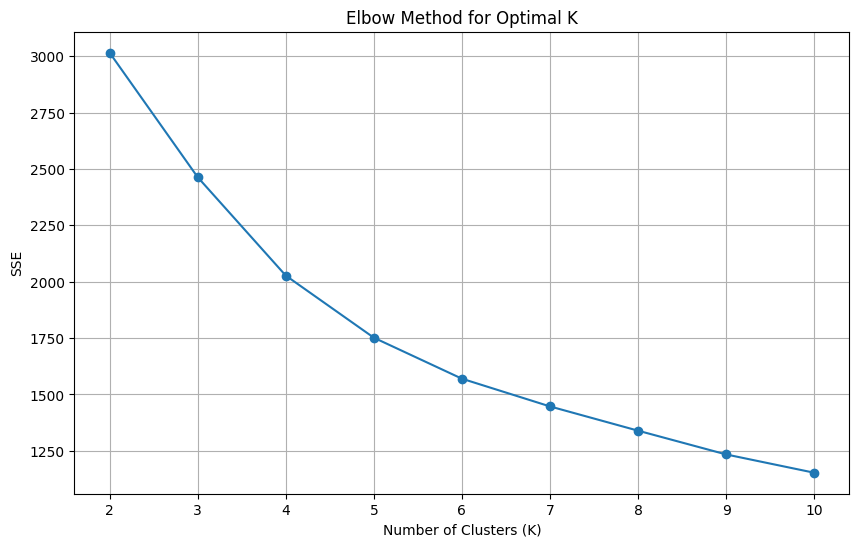

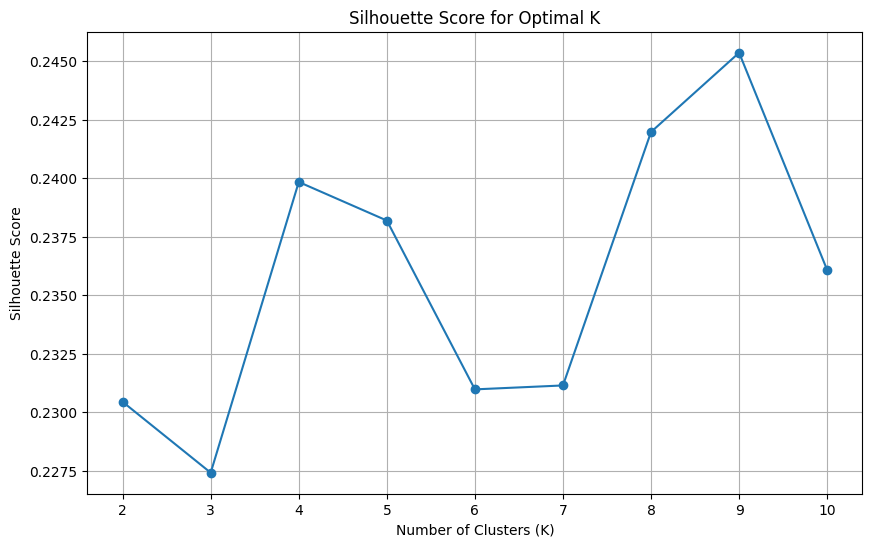

In [ ]:
# 透過視覺化 Elbow Method & Silhouette Score 尋找最佳k值
sse = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Elbow Plot
plt.figure(figsize=(10,6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

print('\n')

# Silhouette Score Plot
plt.figure(figsize=(10,6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

### 3.3 建立 KMeans 模型

In [ ]:
k = 9 # 最佳k值=9
kmeans = KMeans(n_clusters=k, random_state=0)
df['Cluster'] = kmeans.fit_predict(X_scaled)+1

# 四、 群組特徵探索（含統計與視覺化）


### 4.1 群組統計

In [ ]:
# 各群組平均特徵
cluster_means = df.groupby('Cluster')[features].mean().sort_index()

# 各群組訂單數量
cluster_size = df['Cluster'].value_counts().sort_index()

print("---")
print("各群組的平均特徵值：")
print(cluster_means)
print("\n---")
print("各群組的訂單數量：")
print(cluster_size)
print("\n---")
print("各群組的訂單分佈：")
print(df['Cluster'].value_counts(normalize=True).mul(100).round(2))
print("---")
print("各群組的付款方式分佈：")
print(pd.crosstab(df['Cluster'], df['Payment Method'], normalize='index').round(2))
print("\n---")
print("各群組的訂單在一週各天的分佈 (%):")
print(pd.crosstab(df['Cluster'], df['Day of Week'], normalize='index').loc[:, ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].round(2))
print("\n---")
print("各群組的用餐時間偏好分佈 (%):")
print(pd.crosstab(df['Cluster'], df['Meal Time'], normalize='index').round(2))
print("各群組的折扣與優惠分佈：")
print(pd.crosstab(df['Cluster'], df['Discounts and Offers'], normalize='index').round(2))

---
各群組的平均特徵值：
         Order Value  Delivery Fee  Commission Fee  Discount Amount
Cluster                                                            
1        1525.666667     38.160920       80.655172       169.193103
2         885.544554      4.752475      164.594059        55.323762
3        1479.434783     16.086957       85.978261        47.379348
4        1573.654930     37.816901      152.154930        41.705634
5         739.124224     43.043478       91.155280        40.015839
6         524.849398     37.289157      167.927711        38.783434
7        1661.590909     10.151515      124.560606       211.464394
8        1279.144578     34.337349      161.337349       157.236145
9         492.852941     13.039216       94.794118        37.386275

---
各群組的訂單數量：
Cluster
1     87
2    101
3     92
4    142
5    161
6    166
7     66
8     83
9    102
Name: count, dtype: int64

---
各群組的訂單分佈：
Cluster
6    16.6
5    16.1
4    14.2
9    10.2
2    10.1
3     9.2
1     8.7
8     8.3
7   

### 4.2 群組統合報告

In [ ]:
cluster_report = df.groupby('Cluster').agg(
    avg_order_value=('Order Value','mean'),
    order_count=('Order Value','size'),
    avg_commission_fee=('Commission Fee','mean'),
    avg_discount_amount=('Discount Amount','mean'),
    avg_delivery_fee=('Delivery Fee','mean')
).round(2)

# 計算每個指標的排名，並新增對應排名欄位
order_column = []
for col in ['avg_order_value', 'order_count', 'avg_commission_fee', 'avg_discount_amount', 'avg_delivery_fee']:
  cluster_report[col + '_rank'] = cluster_report[col].rank(ascending=False, method='min').astype(int)
  order_column.append(col)
  order_column.append(col + '_rank')

# 依指定欄位順序重新排列 dataframe 欄位
cluster_report = cluster_report[order_column]

display(cluster_report)


,avg_order_value,avg_order_value_rank,order_count,order_count_rank,avg_commission_fee,avg_commission_fee_rank,avg_discount_amount,avg_discount_amount_rank,avg_delivery_fee,avg_delivery_fee_rank
Cluster,,,,,,,,,,
1,1525.67,3,87,7,80.66,9,169.19,2,38.16,2
2,885.54,6,101,5,164.59,2,55.32,4,4.75,9
3,1479.43,4,92,6,85.98,8,47.38,5,16.09,6
4,1573.65,2,142,3,152.15,4,41.71,6,37.82,3
5,739.12,7,161,2,91.16,7,40.02,7,43.04,1
6,524.85,8,166,1,167.93,1,38.78,8,37.29,4
7,1661.59,1,66,9,124.56,5,211.46,1,10.15,8
8,1279.14,5,83,8,161.34,3,157.24,3,34.34,5
9,492.85,9,102,4,94.79,6,37.39,9,13.04,7


### 4.3 群組特徵視覺化

4.3.1 特徵平均值

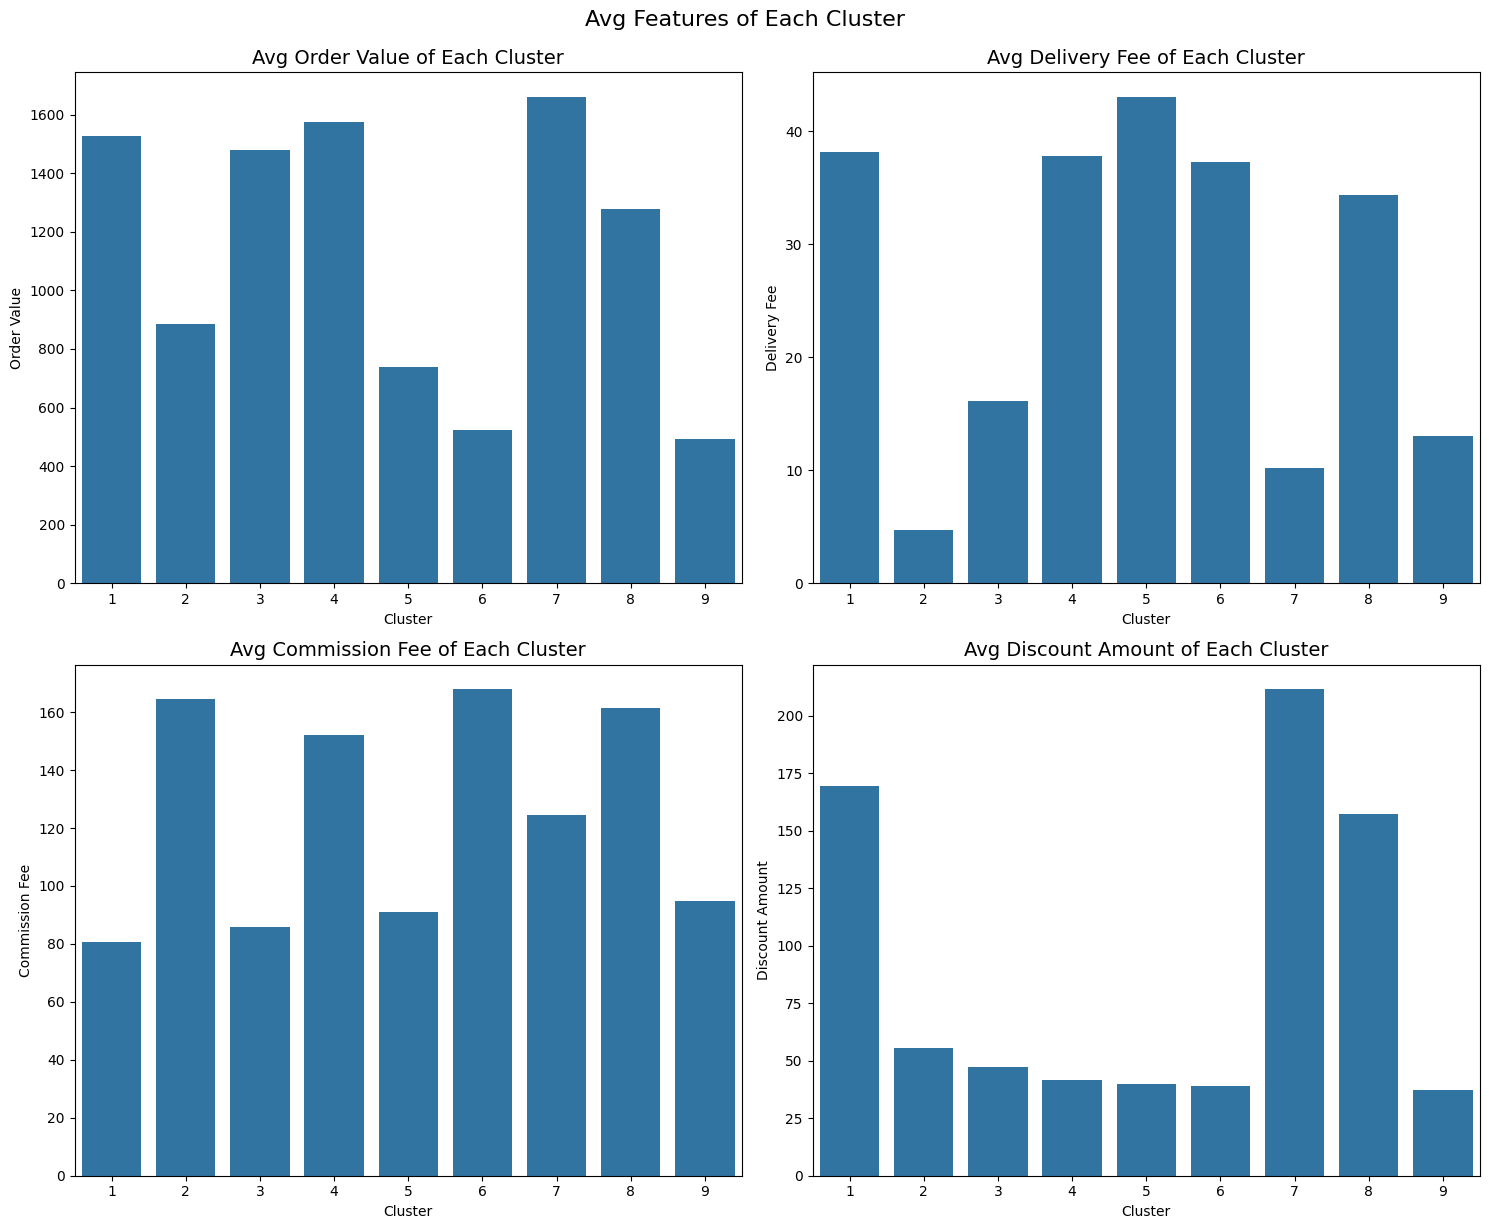

In [ ]:
# 視覺化各群組的特徵平均值
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten() #轉一維，順序為row先跑完
for i, feature in enumerate(features):
    sns.barplot(x='Cluster', y=feature, data=df, ax=axes[i], errorbar=None)
    axes[i].set_title(f'Avg {feature} of Each Cluster', fontsize=14)
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)
plt.tight_layout()
plt.suptitle('Avg Features of Each Cluster', y=1.02, fontsize=16)
plt.show()


4.3.2 付款方式分佈

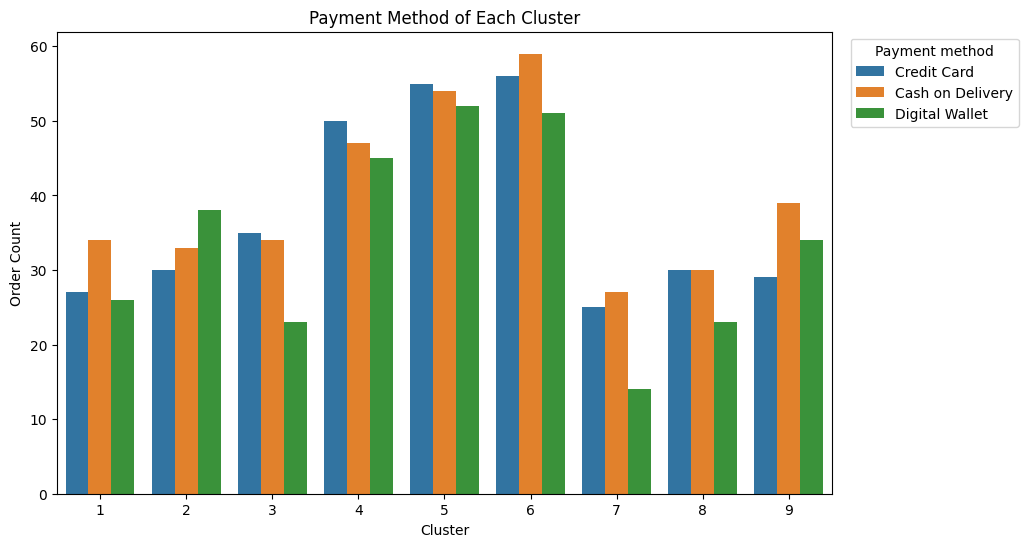

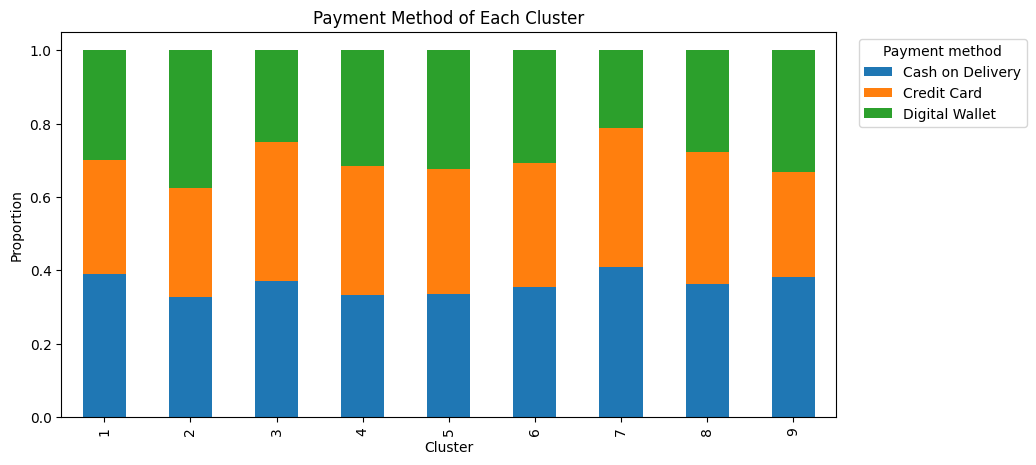

In [ ]:
# Grouped Bar Chart
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', hue='Payment Method', data=df)
plt.title('Payment Method of Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Order Count')
plt.legend(title='Payment method', bbox_to_anchor=(1.25,1), loc='upper right')
plt.show()

# 100% Stacked Bar Chart
pay_crosstable = pd.crosstab(df['Cluster'], df['Payment Method'])
pay_pct = pay_crosstable.div(pay_crosstable.sum(axis=1), axis=0)
pay_pct.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title('Payment Method of Each Cluster')
plt.ylabel('Proportion')
plt.legend(title='Payment method', bbox_to_anchor=(1.02,1))

4.3.3 一週中之訂單分佈

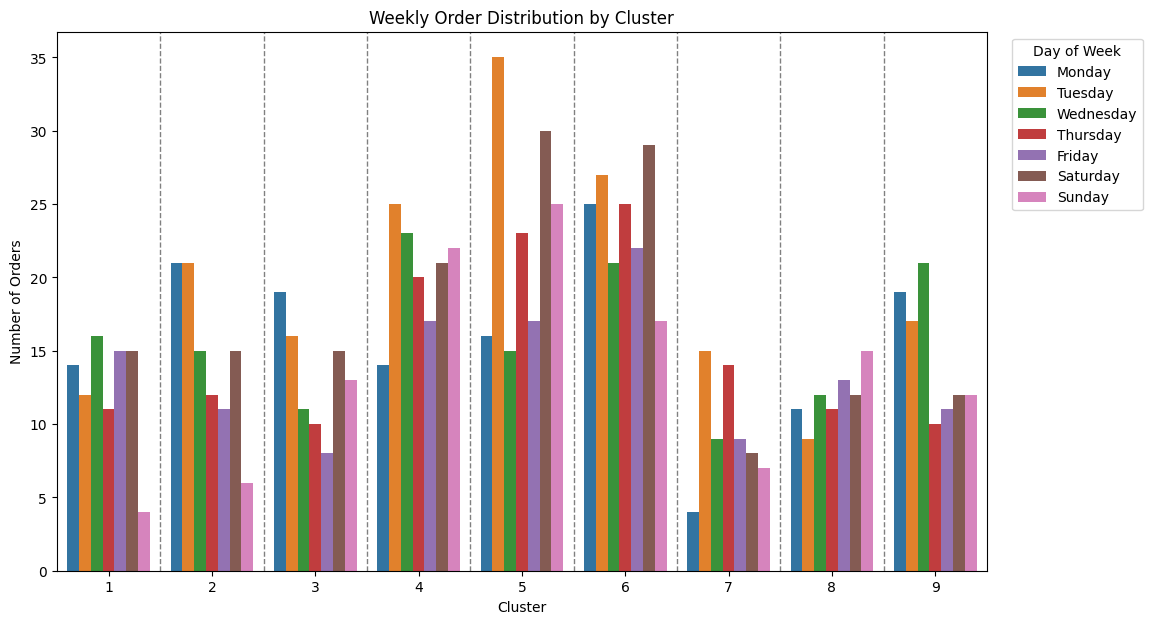

<Figure size 1200x500 with 0 Axes>

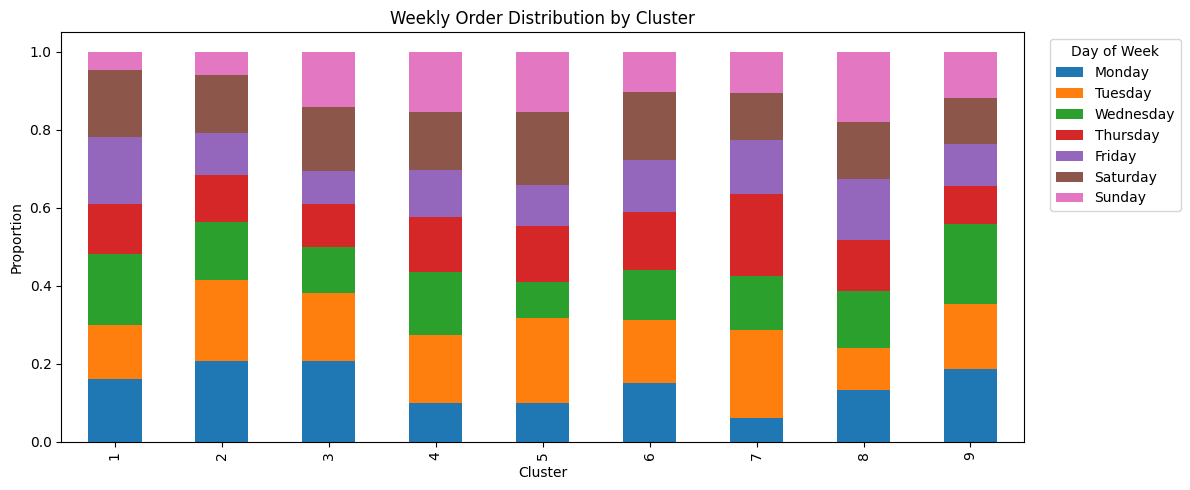

In [ ]:
# Grouped Bar Chart
plt.figure(figsize=(12, 7))
sns.countplot(x='Cluster', hue='Day of Week', data=df, hue_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
k = df['Cluster'].nunique()
for x in range(k - 1):
    plt.axvline(x=x + 0.5, color='gray', linestyle='--', linewidth=1)
plt.title('Weekly Order Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Orders')
plt.legend(title='Day of Week', bbox_to_anchor=(1.175,1), loc='upper right')
plt.show()

# 100% Stacked Bar Chart
dyofwk_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dyofwk_crosstable = pd.crosstab(df['Cluster'], df['Day of Week']).reindex(columns=dyofwk_order, fill_value=0)
dyofwk_vis = dyofwk_crosstable.div(dyofwk_crosstable.sum(axis=1), axis=0)
plt.figure(figsize=(12,5))
dyofwk_vis.plot(kind='bar', stacked=True, figsize=(12,5))
plt.title('Weekly Order Distribution by Cluster')
plt.ylabel('Proportion')
plt.legend(title='Day of Week', bbox_to_anchor=(1.02,1))
plt.tight_layout()
plt.show()

4.3.4 用餐時間分佈

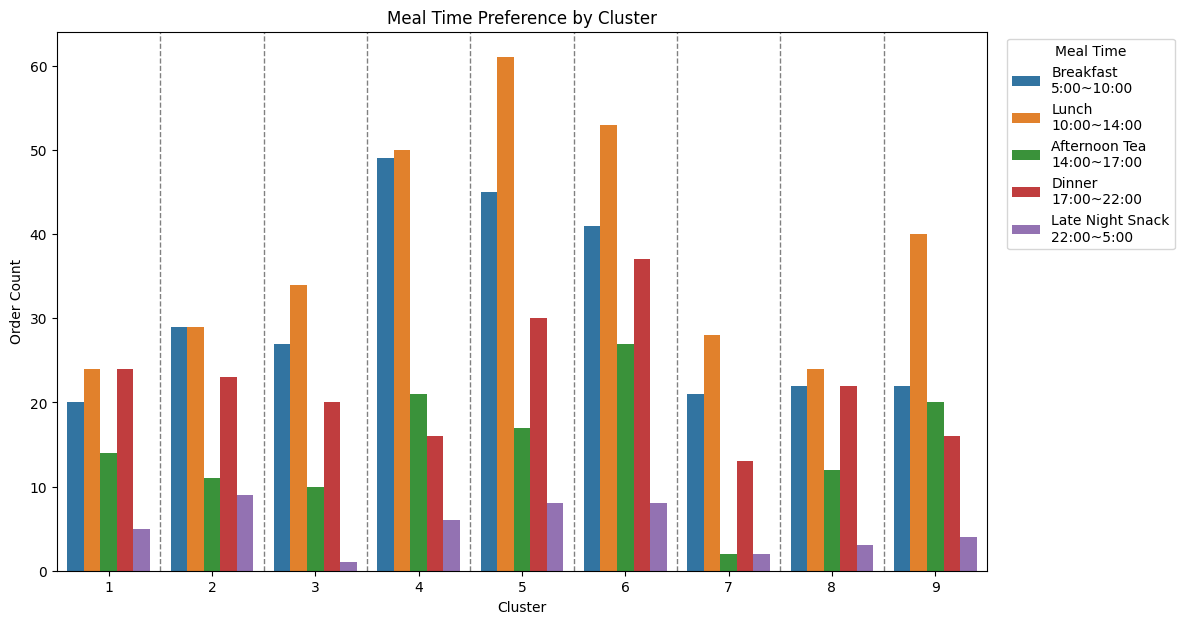

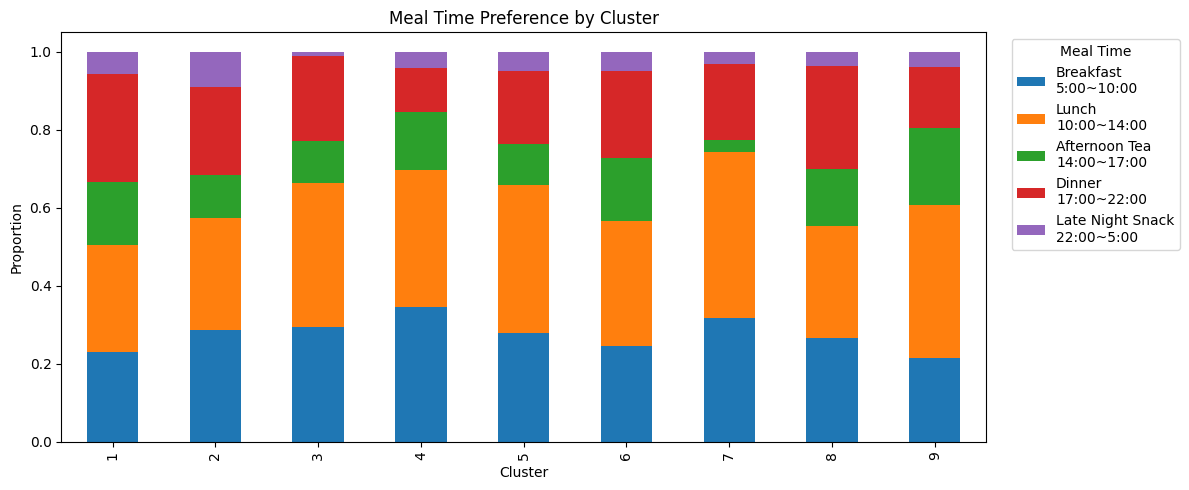

In [ ]:
# Grouped Bar Chart
plt.figure(figsize=(12, 7))
sns.countplot(x='Cluster', hue='Meal Time', data=df, hue_order=['Breakfast\n5:00~10:00', 'Lunch\n10:00~14:00', 'Afternoon Tea\n14:00~17:00', 'Dinner\n17:00~22:00', 'Late Night Snack\n22:00~5:00'])
k = df['Cluster'].nunique()
for x in range(k - 1):
    plt.axvline(x=x + 0.5, color='gray', linestyle='--', linewidth=1)
plt.title('Meal Time Preference by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Order Count')
plt.legend(title='Meal Time', bbox_to_anchor=(1.21,1), loc='upper right')
plt.show()

# 100% Stacked Bar Chart
meal_order = ['Breakfast\n5:00~10:00', 'Lunch\n10:00~14:00', 'Afternoon Tea\n14:00~17:00', 'Dinner\n17:00~22:00', 'Late Night Snack\n22:00~5:00']
meal_crosstable = pd.crosstab(df['Cluster'], df['Meal Time']).reindex(index=cluster_means.index, columns=[c for c in meal_order if c in df['Meal Time'].unique()]).fillna(0)
meal_crosstable.div(meal_crosstable.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(12,5))
plt.title('Meal Time Preference by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Meal Time', bbox_to_anchor=(1.02,1))
plt.tight_layout()
plt.show()

4.3.5 折扣使用分佈

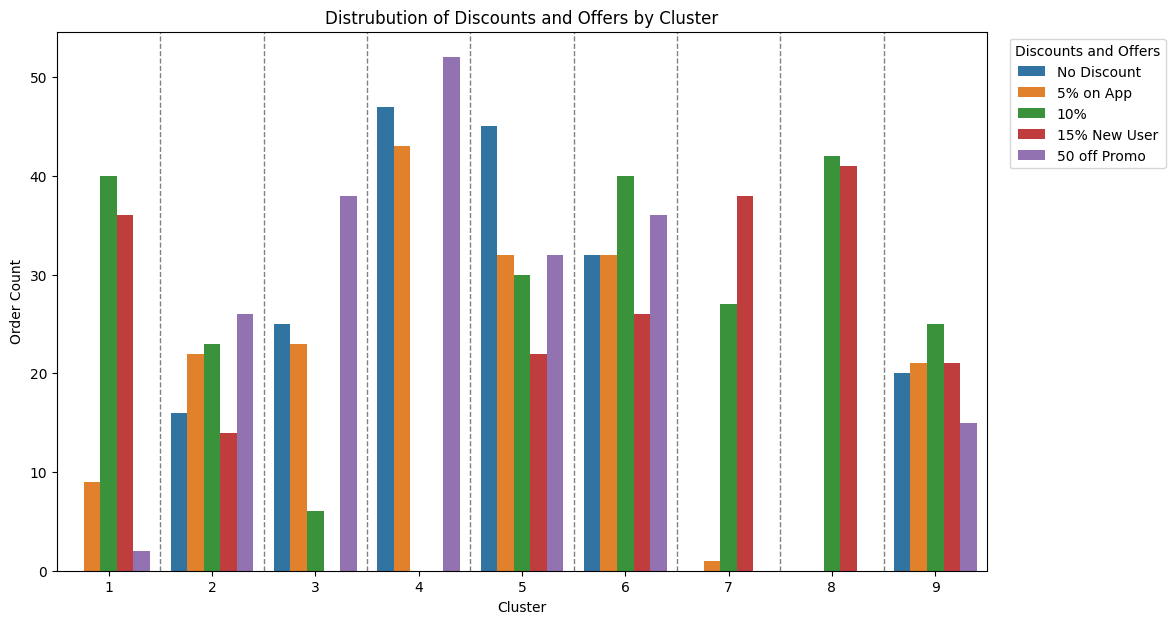

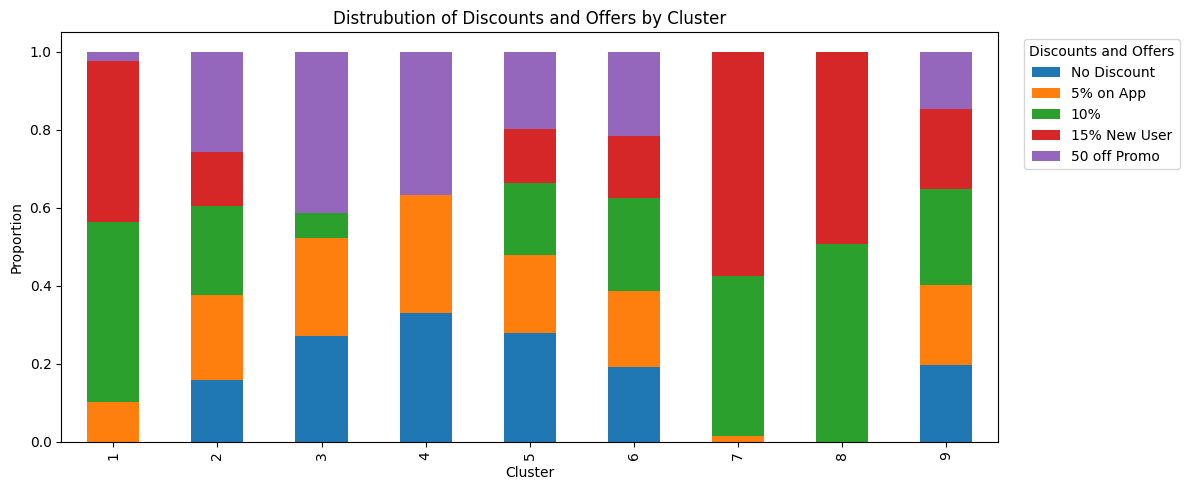

In [ ]:
# Grouped Bar Chart
plt.figure(figsize=(12, 7))
sns.countplot(x='Cluster', hue='Discounts and Offers', data=df, hue_order=['No Discount', '5% on App', '10%', '15% New User', '50 off Promo'])
k = df['Cluster'].nunique()
for x in range(k - 1):
    plt.axvline(x=x + 0.5, color='gray', linestyle='--', linewidth=1)
plt.title('Distrubution of Discounts and Offers by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Order Count')
plt.legend(title='Discounts and Offers', bbox_to_anchor=(1.2,1), loc='upper right')
plt.show()

# 100% Stacked Bar Chart
discount_order = ['No Discount','5% on App','10%','15% New User','50 off Promo']
discount_crosstable = pd.crosstab(df['Cluster'], df['Discounts and Offers']).reindex(index=cluster_means.index, columns=[c for c in discount_order if c in df['Discounts and Offers'].unique()]).fillna(0)
discount_crosstable.div(discount_crosstable.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(12,5))
plt.title('Distrubution of Discounts and Offers by Cluster')
plt.ylabel('Proportion')
plt.legend(title='Discounts and Offers', bbox_to_anchor=(1.02,1))
plt.tight_layout()
plt.show()

# 五、 群組數值統整、解讀與商業策略

In [ ]:
# 1. 核心分析指標公式：
# 平台單筆收益 = Commission Fee + Delivery Fee - Discount Amount - Payment Processing Fee
# 群組總收益 = 平台單筆收益 * 群組訂單總數

# 2. 各cluster數據、特徵與指標計算
cluster_data = {
    'Cluster ID': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    '訂單數': [87, 101, 92, 142, 161, 166, 66, 83, 102],
    '平均訂單價值': [1525.67, 885.54, 1479.43, 1573.65, 739.12, 524.85, 1661.59, 1279.14, 492.85],
    '平均 Commission Fee': [80.66, 164.59, 85.98, 152.15, 91.16, 167.93, 124.56, 161.34, 94.79],
    '平均 Delivery Fee': [38.16, 4.75, 16.09, 37.82, 43.04, 37.29, 10.15, 34.34, 13.04],
    '平均 Discount Amount': [169.19, 55.32, 47.38, 41.71, 40.02, 38.78, 211.46, 157.24, 37.39],
    '平均 Payment Processing Fee': [30, 25, 28, 30, 20, 15, 35, 28, 15],
    '關鍵行為特徵': [
        '訂單高比例(87%)使用 10% 折扣或 15% New User折扣',
        '低運費 (4.75元) 與高佣金 (164.59元)',
        '顯著依賴 50 off 折扣 (41%)',
        '33% 訂單無折扣 (高價值貢獻)',
        '週二訂單數量佔比高 (22%)',
        '高佣金率 (32%)',
        '折扣成本最高 (211元)、訂單高比例(99%)使用 10% 折扣或 15% New User折扣',
        '所有訂單(100%)皆使用 10% 折扣或 15% New User折扣',
        '午餐時段之訂單佔比較集中 (39%)'
    ]
}
df_report = pd.DataFrame(cluster_data)
# print(df_report)

# 計算核心指標
df_report['平台單筆收益'] = (df_report['平均 Commission Fee'] + df_report['平均 Delivery Fee']) - (df_report['平均 Discount Amount'] + df_report['平均 Payment Processing Fee'])
df_report['群組總收益'] = df_report['平台單筆收益'] * df_report['訂單數']
df_report['佣金率 (%)'] = (df_report['平均 Commission Fee'] / df_report['平均訂單價值']) * 100
df_report = df_report.round(2)

# 3. 定義優先級與客制化策略
df_report = df_report.sort_values(by='群組總收益', ascending=False).reset_index(drop=True)

# 定義優先級
priority_map = {
    'P1 (立即止損)': df_report[df_report['群組總收益'] <= 0].index,
    'P2 (鞏固核心)': df_report[df_report['群組總收益'] > 10000].index,
    'P3 (優化潛力)': df_report[(df_report['群組總收益'] > 0) & (df_report['群組總收益'] <= 10000)].index
}
df_report['優先級'] = ''
for priority, indices in priority_map.items():
    df_report.loc[indices, '優先級'] = priority

# 行動策略
strategy_map = {
    # P1
    1: '核心策略 (止損)：因其嚴重虧損(-80元)，立即顯著提高 10% 折扣以及15% New User折扣之消費門檻，留下可貢獻利潤之客戶，若無法轉化為付費會員則停止投入行銷資源以避免虧損。',
    7: '核心策略 (止損)：因其虧損最嚴重(-111元)，然其訂單價值為所有群組中最高，故在不流失客戶的情況下，立刻停止現金流失。採取淘汰直接折扣策略，改為「平台現金回饋」制度，讓平台能先收到訂單全額，並迫使客戶為了用掉回饋金而再次消費。',
    # P2
    2: '核心策略：組合銷售。利用其「低運費高佣金」的獨特優勢，推廣高利潤的加價購商品。',
    4: '核心策略：VIP 維護。有33% 訂單未使用折扣，反映該客群對價格敏感度較低，推測其可能對平台有高度黏著與支付意願，故提供「優先派單」、「專屬客服」等非折扣之服務升級，鞏固其高價值與忠誠度。',
    5: '核心策略：利用該客群於週二訂單量明顯高峰的特性，推出週二專屬加價購套餐及飲品組合優惠，並設計滿額免運及限定加購飲品，誘導會員增加單筆訂單金額，最大化週二訂單利潤貢獻。',
    6: '核心策略：鎖定該客群主要訂購之餐廳群，該群餐廳平均佣金率高達32%。透過獨家合作協議，結合優先曝光、專屬行銷活動、專屬客服及物流優先派單等方式，強化與這批高價值餐廳之合作關係，並複製成功模式至類似餐廳，以提升平台整體盈利能力。',
    # P3
    3: '核心策略：減少消費者對50元折扣（佔41%）之依賴，轉而推廣「滿額折抵」及「高佣金餐廳限定券」，以提升促銷效率及平台利潤。',
    8: '核心策略 (優化利潤)：因其利潤過薄(每單約+10元)，可溫和提高非會員 10%折扣以及15% New User折扣之消費門檻，同時積極推動用戶訂閱付費會員，以擴大利潤空間。',
    9: '核心策略：提升客單價。基於午餐時段之訂單佔比較集中（39%），實施「午間滿 600 元減免運費」策略，鼓勵該客群增加客單價。'
}

df_report['行動策略'] = df_report['Cluster ID'].map(strategy_map)


# 最終策略報告
print("【客戶分群與商業策略報告】")

# 排列欄位順序
final_columns = [
    '優先級',
    'Cluster ID',
    '群組總收益',
    '平台單筆收益',
    '關鍵行為特徵',
    '訂單數',
    '平均訂單價值',
    '平均 Commission Fee',
    '佣金率 (%)',
    '平均 Discount Amount',
    '行動策略'
]
df_final_report = df_report[final_columns]
display(df_final_report)

【客戶分群與商業策略報告】


,優先級,Cluster ID,群組總收益,平台單筆收益,關鍵行為特徵,訂單數,平均訂單價值,平均 Commission Fee,佣金率 (%),平均 Discount Amount,行動策略
0,P2 (鞏固核心),6,25139.04,151.44,高佣金率 (32%),166,524.85,167.93,32.00,38.78,核心策略：保護最高佣金率(32%)餐廳。與該類型餐廳簽訂獨家合作，並複製此商業模式。
1,P2 (鞏固核心),4,16792.92,118.26,33% 訂單無折扣 (高價值貢獻),142,1573.65,152.15,9.67,41.71,核心策略：VIP 維護。提供「優先派單」、「專屬客服」等非折扣的服務升級，鞏固其高價值與忠誠度。
2,P2 (鞏固核心),5,11942.98,74.18,週二訂單佔比顯著較高 (22%),161,739.12,91.16,12.33,40.02,核心策略：利用其「週二訂單顯著較高」的特性，推出「週二會員日」活動，將此穩定流量轉化為更高利潤。
3,P3 (優化潛力),2,8991.02,89.02,低運費 (4.75元) 與高佣金 (164.59元),101,885.54,164.59,18.59,55.32,核心策略：交叉銷售。利用其「低運費高佣金」的獨特優勢，推廣高利潤的加價購商品。
4,P3 (優化潛力),9,5654.88,55.44,午餐時段之訂單佔比較集中 (39%),102,492.85,94.79,19.23,37.39,核心策略：提升客單價。利用其「午餐集中(39%)」的特性，實施「午間滿 600 元減免運費」策略。
5,P3 (優化潛力),3,2455.48,26.69,顯著依賴 50 off 折扣 (41%),92,1479.43,85.98,5.81,47.38,核心策略：淘汰其依賴的 50 off 折扣(41%)，替換為「滿額折抵」或「高佣金餐廳限定券」。
6,P3 (優化潛力),8,866.52,10.44,所有訂單(100%)皆使用 10% 折扣或 15% New User折扣,83,1279.14,161.34,12.61,157.24,核心策略 (優化利潤)：因其利潤過薄(+10元)，應溫和提高非會員 10%折扣以及15% New User折扣之消費門檻，並引導其訂閱付費會員以擴大利潤空間。
7,P1 (立即止損),1,-6992.19,-80.37,訂單高比例(87%)使用 10% 折扣或 15% New User折扣,87,1525.67,80.66,5.29,169.19,核心策略 (止損)：因其嚴重虧損(-80元)，立即顯著提高 10% 折扣以及15% New User折扣之消費門檻，，留下可貢獻利潤之客戶，若無法轉化為付費會員則停止投入行銷資源以避免虧損。
8,P1 (立即止損),7,-7375.50,-111.75,折扣成本最高 (211元)、訂單高比例(99%)使用 10% 折扣或 15% New User折扣,66,1661.59,124.56,7.50,211.46,核心策略 (止損)：因其虧損最嚴重(-111元)，淘汰直接折扣，改為「平台現金回饋」制度，在不流失客戶的前提下立即停止現金流失。
